# Semantic Image Segmentation for Self-Driving Cars

### Background 

Identifying common objects is an important step to building a self-driving system. In this project I'll be attempting to train a nural network to identify 12 classes of objects in the DriveSeg datase https://agelab.mit.edu/driveseg 
The ojects include vehicles, pedestrians, roads, sidewalks,traffic lights and other ojects thet you would normally encounter while driving. 

This dataset was created through hours of manual work. With a good model the amount of work required to label a dataset like this could be vastly reduced. We will get into some example of what the data looks like in the exploration steps below.

In [74]:
import pandas as pd
import numpy as np
import os
from pylab import rcParams
from skimage.color import label2rgb
from skimage.io import imshow
import matplotlib.pyplot as plt

from IPython.display import clear_output

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation,Conv2D, LSTM, ConvLSTM2D, MaxPool2D, Reshape, Flatten, Input, Dropout
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split as tts

In [2]:
rcParams['figure.figsize'] = (12, 10)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Exploration
The main componenets of the dataset are the directory 'frames' containg the training images and the directory 'labels' conating the images with class values. The full dataset is over 3GB so I didn't inclued it in the projec repo. I've only included the version the I preprocessed. If you would like to download the original data you can find it at the link in the background above.

In [4]:
base_path = '/content/drive/MyDrive/Datasets/DriveSeg (Manual)'
os.chdir(base_path)
os.listdir()

['config.json',
 'demo_video.mp4',
 'README.txt',
 'frames',
 '__MACOSX',
 'model.png',
 'labels',
 'mydask.png',
 'preprocessed_15_pct.npz',
 'preprocessed_25_pct.npz',
 'test_preprocessed.npz']

In [5]:
img_list = os.listdir('frames')
img_list.sort()
img_list

['.DS_Store',
 '000000_img.jpg',
 '000001_img.jpg',
 '000002_img.jpg',
 '000003_img.jpg',
 '000004_img.jpg',
 '000005_img.jpg',
 '000006_img.jpg',
 '000007_img.jpg',
 '000008_img.jpg',
 '000009_img.jpg',
 '000010_img.jpg',
 '000011_img.jpg',
 '000012_img.jpg',
 '000013_img.jpg',
 '000014_img.jpg',
 '000015_img.jpg',
 '000016_img.jpg',
 '000017_img.jpg',
 '000018_img.jpg',
 '000019_img.jpg',
 '000020_img.jpg',
 '000021_img.jpg',
 '000022_img.jpg',
 '000023_img.jpg',
 '000024_img.jpg',
 '000025_img.jpg',
 '000026_img.jpg',
 '000027_img.jpg',
 '000028_img.jpg',
 '000029_img.jpg',
 '000030_img.jpg',
 '000031_img.jpg',
 '000032_img.jpg',
 '000033_img.jpg',
 '000034_img.jpg',
 '000035_img.jpg',
 '000036_img.jpg',
 '000037_img.jpg',
 '000038_img.jpg',
 '000039_img.jpg',
 '000040_img.jpg',
 '000041_img.jpg',
 '000042_img.jpg',
 '000043_img.jpg',
 '000044_img.jpg',
 '000045_img.jpg',
 '000046_img.jpg',
 '000047_img.jpg',
 '000048_img.jpg',
 '000049_img.jpg',
 '000050_img.jpg',
 '000051_img.jpg'

In [6]:
labels_list = os.listdir('labels')
labels_list.sort()
labels_list

['000000_gt_id.png',
 '000001_gt_id.png',
 '000002_gt_id.png',
 '000003_gt_id.png',
 '000004_gt_id.png',
 '000005_gt_id.png',
 '000006_gt_id.png',
 '000007_gt_id.png',
 '000008_gt_id.png',
 '000009_gt_id.png',
 '000010_gt_id.png',
 '000011_gt_id.png',
 '000012_gt_id.png',
 '000013_gt_id.png',
 '000014_gt_id.png',
 '000015_gt_id.png',
 '000016_gt_id.png',
 '000017_gt_id.png',
 '000018_gt_id.png',
 '000019_gt_id.png',
 '000020_gt_id.png',
 '000021_gt_id.png',
 '000022_gt_id.png',
 '000023_gt_id.png',
 '000024_gt_id.png',
 '000025_gt_id.png',
 '000026_gt_id.png',
 '000027_gt_id.png',
 '000028_gt_id.png',
 '000029_gt_id.png',
 '000030_gt_id.png',
 '000031_gt_id.png',
 '000032_gt_id.png',
 '000033_gt_id.png',
 '000034_gt_id.png',
 '000035_gt_id.png',
 '000036_gt_id.png',
 '000037_gt_id.png',
 '000038_gt_id.png',
 '000039_gt_id.png',
 '000040_gt_id.png',
 '000041_gt_id.png',
 '000042_gt_id.png',
 '000043_gt_id.png',
 '000044_gt_id.png',
 '000045_gt_id.png',
 '000046_gt_id.png',
 '000047_gt_i

In [7]:
labels_list[-1]

'004999_gt_id.png'

#### There should be 5000 images in the frames and labels directoris. 

In [8]:
len(img_list)

5001

In [9]:
len(labels_list)

5000

In [10]:
img_list[0]

'.DS_Store'

In [11]:
# We can remodve this unwanted file
img_list.remove('.DS_Store')
img_list[0]

'000000_img.jpg'

In [12]:
len(img_list)

5000

The dataset contains a config.json file with the class info. lets take a look at it by loading it into a dataframe


In [13]:
class_info_df = pd.read_json('config.json')
class_info_df.drop('name', axis=1, inplace=True)
for key in class_info_df.labels[0].keys():
  class_info_df[key] = class_info_df.labels.apply(lambda x: x[key])

class_info_df.drop('labels', axis=1, inplace=True)
class_info_df

,label,color,id
0,vehicle,"[0, 0, 142]",1
1,pedestrian,"[220, 20, 60]",2
2,road,"[128, 64, 128]",3
3,sidewalk,"[244, 35, 232]",4
4,bicycle,"[119, 11, 32]",5
5,motorcycle,"[0, 0, 230]",6
6,building,"[70, 70, 70]",7
7,terrain,"[152, 251, 152]",8
8,vegetation,"[107, 142, 35]",9
9,pole,"[153, 153, 153]",10


In [14]:
# There are 12 classes but the numbers start at 1 we will use class 0 to represent unknown objects

new_row = pd.DataFrame(['unknown', [0,0,0], 0]).transpose()
new_row.columns = class_info_df.columns
class_info_df = class_info_df.append(new_row).sort_values('id').reset_index()
class_info_df.drop('index', axis=1, inplace=True)
class_info_df

,label,color,id
0,unknown,"[0, 0, 0]",0
1,vehicle,"[0, 0, 142]",1
2,pedestrian,"[220, 20, 60]",2
3,road,"[128, 64, 128]",3
4,sidewalk,"[244, 35, 232]",4
5,bicycle,"[119, 11, 32]",5
6,motorcycle,"[0, 0, 230]",6
7,building,"[70, 70, 70]",7
8,terrain,"[152, 251, 152]",8
9,vegetation,"[107, 142, 35]",9


In [15]:
# We will make a dataframe of the paths to the images and labels for batch loading and preprocessing later
img_dir = 'frames/'
label_dir = 'labels/'

img_paths = [img_dir + img for img in img_list]
label_paths = [label_dir + label for label in labels_list]

df = pd.DataFrame(img_paths)

df.columns = ['X_path']

df['label_path'] = label_paths
df

,X_path,label_path
0,frames/000000_img.jpg,labels/000000_gt_id.png
1,frames/000001_img.jpg,labels/000001_gt_id.png
2,frames/000002_img.jpg,labels/000002_gt_id.png
3,frames/000003_img.jpg,labels/000003_gt_id.png
4,frames/000004_img.jpg,labels/000004_gt_id.png
...,...,...
4995,frames/004995_img.jpg,labels/004995_gt_id.png
4996,frames/004996_img.jpg,labels/004996_gt_id.png
4997,frames/004997_img.jpg,labels/004997_gt_id.png
4998,frames/004998_img.jpg,labels/004998_gt_id.png


In [16]:
# Lets take a look at one of the images
image = load_img(df.X_path[0])
image

Output hidden; open in https://colab.research.google.com to view.

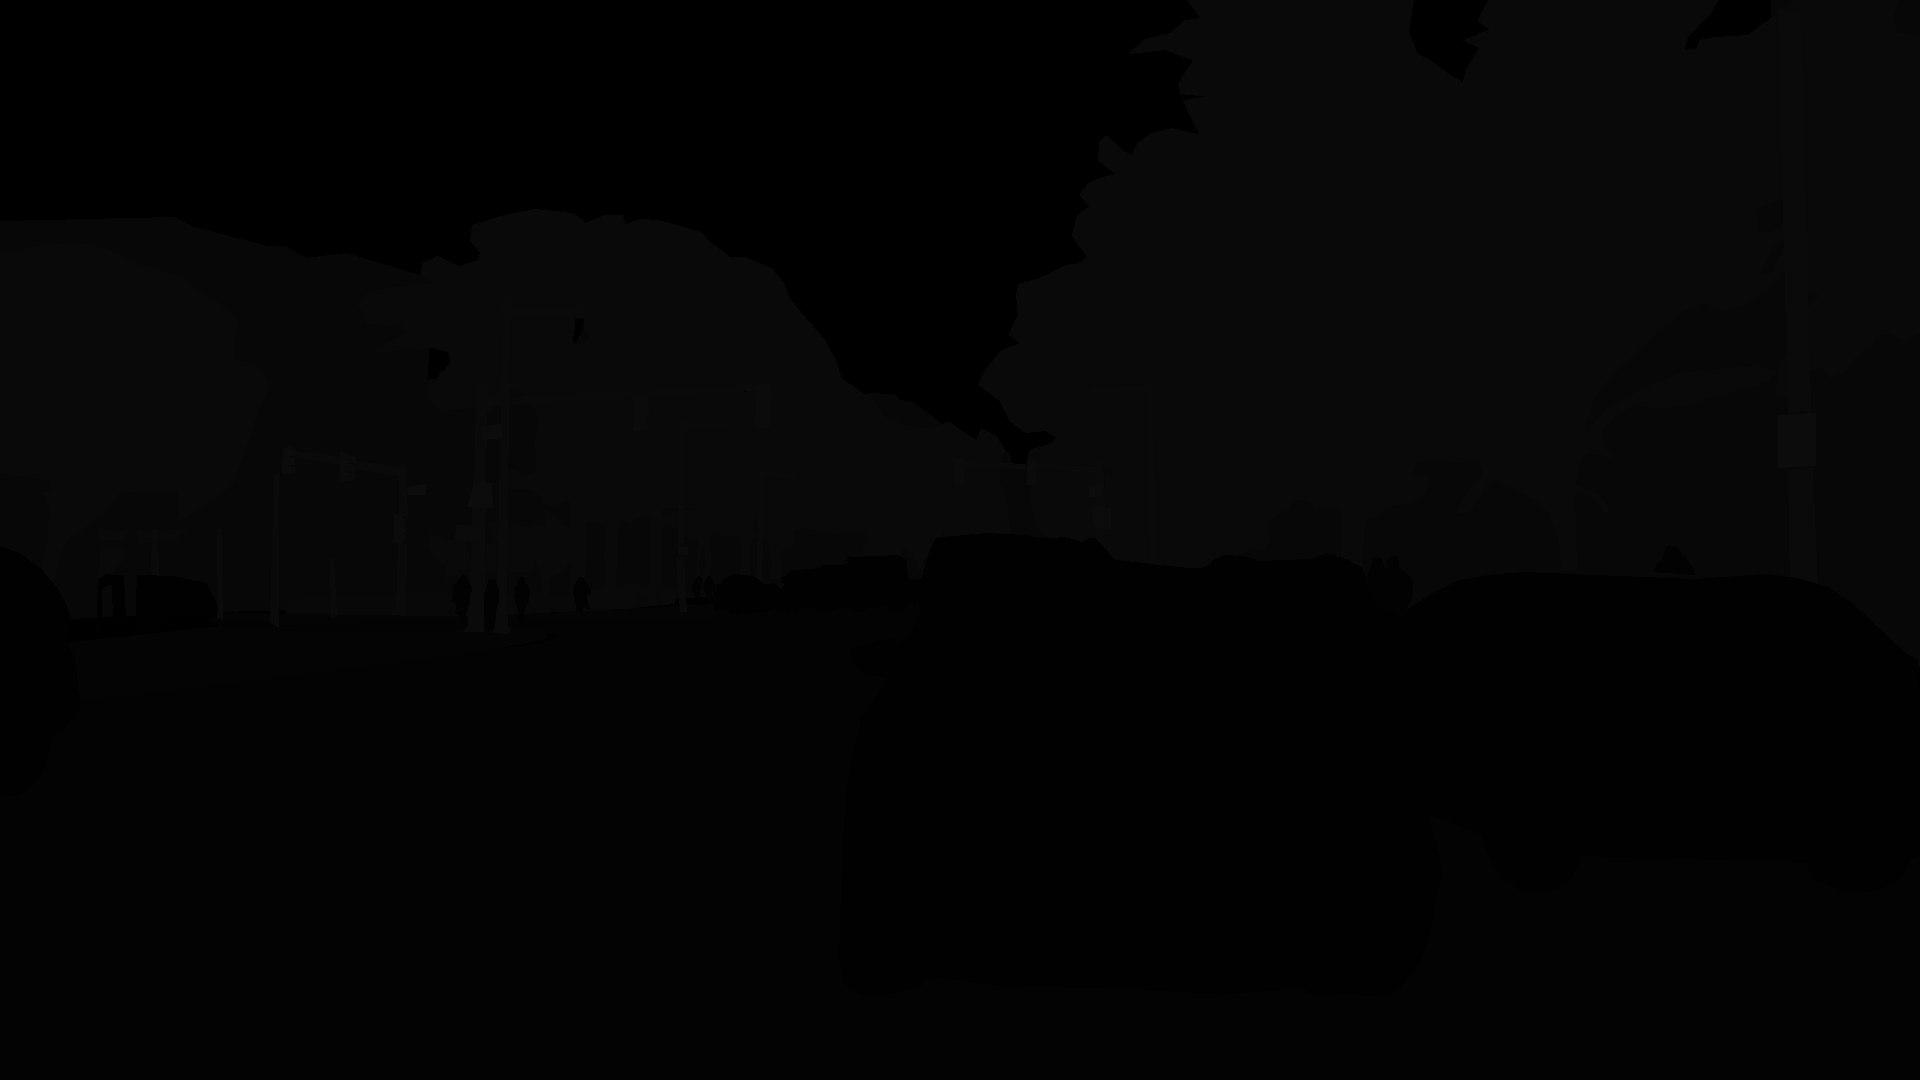

In [17]:
# Now lets take a look at the corresponding labels
load_img(df.label_path[0])

In [18]:
# Not much to look at. Lets convert it to an array and see if we can interpret this

image_array = img_to_array(load_img(df.label_path[0]))
image_array

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [7., 7., 7.],
        [7., 7., 7.],
        [7., 7., 7.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [7., 7., 7.],
        [7., 7., 7.],
        [7., 7., 7.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [7., 7., 7.],
        [7., 7., 7.],
        [7., 7., 7.]],

       ...,

       [[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        ...,
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]],

       [[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        ...,
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]],

       [[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        ...,
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]]], dtype=float32)

In [19]:
# Not every image contains all 12 labels
set(image_array.flatten().astype(int))

{0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12}

In [20]:
image_array.shape

(1080, 1920, 3)

The array is in standard rgb image format with the same class label for each pixel repeated accross all three color channels. I created the function below to map the colors from the config.json onto the label image so we can visualize it

In [21]:
def color_image_from_labels(label_array, class_info_df):
  ouput = np.zeros(label_array.shape + (3,), dtype='uint8')

  for class_id in class_info_df.id:
    ouput[label_array == class_id] = np.array(class_info_df.loc[lambda x: x.id == class_id].color.values[0], dtype='uint8')
  
  return ouput

In [22]:
# to use the funtion we will first load the image as grayscale to remove the redudnant color chanels
label_image = load_img(df.label_path[0], color_mode='grayscale')
label_array = img_to_array(label_image)
label_array

array([[[0.],
        [0.],
        [0.],
        ...,
        [7.],
        [7.],
        [7.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [7.],
        [7.],
        [7.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [7.],
        [7.],
        [7.]],

       ...,

       [[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]]], dtype=float32)

In [23]:
label_array = label_array.reshape((label_array.shape[0], label_array.shape[1]))

In [24]:
label_array

array([[0., 0., 0., ..., 7., 7., 7.],
       [0., 0., 0., ..., 7., 7., 7.],
       [0., 0., 0., ..., 7., 7., 7.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]], dtype=float32)

In [25]:
label_array.shape

(1080, 1920)

In [26]:
# now that we have a 2 dimentional array we can use our function, we pass in our dataframe with the associated class colors
label_color_image = color_image_from_labels(label_array, class_info_df)
label_color_image

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 70,  70,  70],
        [ 70,  70,  70],
        [ 70,  70,  70]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 70,  70,  70],
        [ 70,  70,  70],
        [ 70,  70,  70]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 70,  70,  70],
        [ 70,  70,  70],
        [ 70,  70,  70]],

       ...,

       [[128,  64, 128],
        [128,  64, 128],
        [128,  64, 128],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]],

       [[128,  64, 128],
        [128,  64, 128],
        [128,  64, 128],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]],

       [[128,  64, 128],
        [128,  64, 128],
        [128,  64, 128],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]]

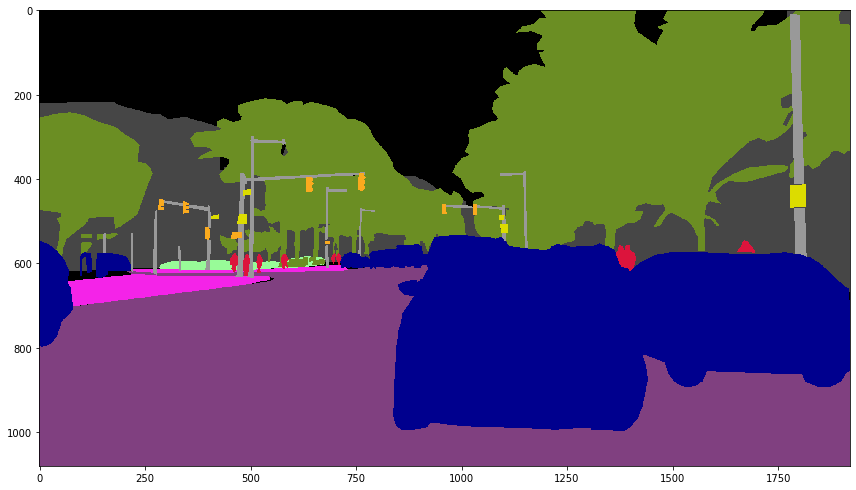

In [28]:
# now we can take a look at it
imshow(label_color_image)

In [45]:
color_list = ['red', 'darkblue', 'pink', 'cyan', 'magenta', 'maroon', 'blue', 'gray',
              'palegreen', 'darkgreen', 'purple', 'darkorange', 'yellow']

len(color_list)

13

In [30]:
# scikit-image has a nice function for visualizing this kind of segmentation data
# We pass in our 2d label array and our image

image_array = img_to_array(image, dtype='uint8')
image_overlay = label2rgb(label_array, image_array, colors=color_list, bg_label=0)
image_overlay

array([[[0.52179071, 0.52179071, 0.52179071],
        [0.52179071, 0.52179071, 0.52179071],
        [0.52179071, 0.52179071, 0.52179071],
        ...,
        [0.41891792, 0.11891792, 0.41891792],
        [0.41617282, 0.11617282, 0.41617282],
        [0.41342773, 0.11342773, 0.41342773]],

       [[0.52179071, 0.52179071, 0.52179071],
        [0.52179071, 0.52179071, 0.52179071],
        [0.52179071, 0.52179071, 0.52179071],
        ...,
        [0.41184929, 0.11184929, 0.41184929],
        [0.4063591 , 0.1063591 , 0.4063591 ],
        [0.403614  , 0.103614  , 0.403614  ]],

       [[0.52179071, 0.52179071, 0.52179071],
        [0.52179071, 0.52179071, 0.52179071],
        [0.52179071, 0.52179071, 0.52179071],
        ...,
        [0.4063591 , 0.1063591 , 0.4063591 ],
        [0.403614  , 0.103614  , 0.403614  ],
        [0.4008689 , 0.1008689 , 0.4008689 ]],

       ...,

       [[0.50104357, 0.42694357, 0.43984357],
        [0.49555337, 0.42145337, 0.43435337],
        [0.49280827, 0

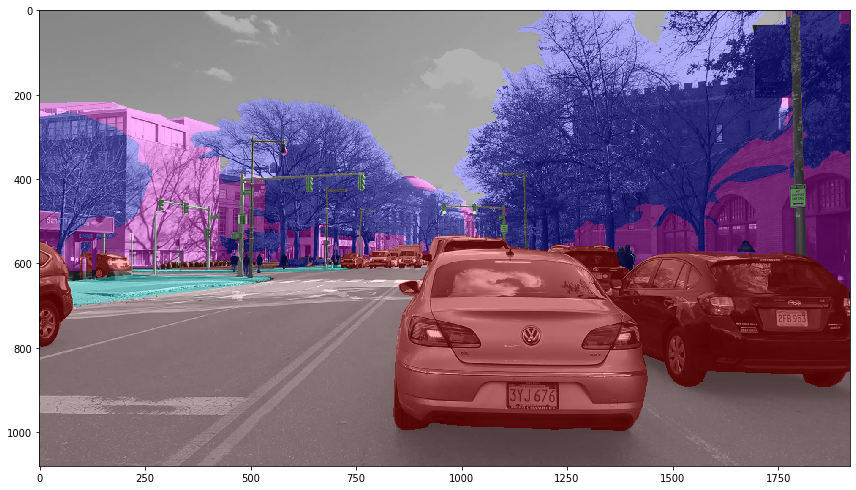

In [31]:
# now we can show it
imshow(image_overlay)

For a full demo of the data like this you can check out this video provided by the creators of the dataset:

 https://www.youtube.com/watch?v=XYGDQO924HY
 

In [27]:
# below are 2 functions I created to preprocess the images and labels
def preprocess_image(image_path, target_shape, verbose=True):
    if verbose:
        clear_output(wait=True)
        print(f'Processing file at: {image_path}')
    
    # The images are hard to work with at full size with the computing resources 
    # I have available so I will load them as grayscal and downscale them as well
    image = load_img(image_path, target_size=target_shape, color_mode='grayscale')
    img_array = img_to_array(image, dtype='uint8')
    # Rescale the image values to the range 0 to 1
    return (img_array * (1./255)).astype('float32')

def create_labels_array(label_path, target_shape, verbose=True):
    if verbose:
        clear_output(wait=True)
        print(f'Processing file at: {label_path}')

    # The label images need to be scaled to the same size as the regular images
    seg_map = load_img(label_path, target_size=target_shape, color_mode='grayscale')
    seg_map_array = img_to_array(seg_map, dtype='uint8')
    
    # We will convert the labels to a 2d array as we did in the example above
    label_array = seg_map_array.reshape(target_shape)

    n_classes = 13
    # We will use the to_categorical function from keras.utils to one-hot encode our labels
    return to_categorical(label_array, num_classes=n_classes, dtype='uint8')

In [28]:
# After some trial and error I've decided to work with the images at 15% scale
# Here I'll define some constants to keep everything consistant
NUM_CLASSES = 13
SCALE_FACTOR = 0.15
ORIGINAL_IMAGE_SHAPE = (1080, 1920, 3)
RESIZED_IMAGE_SHAPE = (int(ORIGINAL_IMAGE_SHAPE[0] * SCALE_FACTOR), int(ORIGINAL_IMAGE_SHAPE[1] * SCALE_FACTOR))
PREPROCESS_IMAGE_SHAPE = RESIZED_IMAGE_SHAPE + (1, )
FLATTENED_IMAGE_SHAPE = RESIZED_IMAGE_SHAPE[0] * RESIZED_IMAGE_SHAPE[1]
OUTPUT_SHAPE = RESIZED_IMAGE_SHAPE + (NUM_CLASSES, )

In [29]:
# after converting to grascale and downscalling to 15% this will be the size of the images the we will use in our models 
PREPROCESS_IMAGE_SHAPE

(162, 288, 1)

In [30]:
FLATTENED_IMAGE_SHAPE

46656

In [31]:
RESIZED_IMAGE_SHAPE

(162, 288)

In [32]:
# each of the pixels in the image will have a one-hot encoded label so this will be the shape of our model output
OUTPUT_SHAPE

(162, 288, 13)

Processing file at: frames/000000_img.jpg


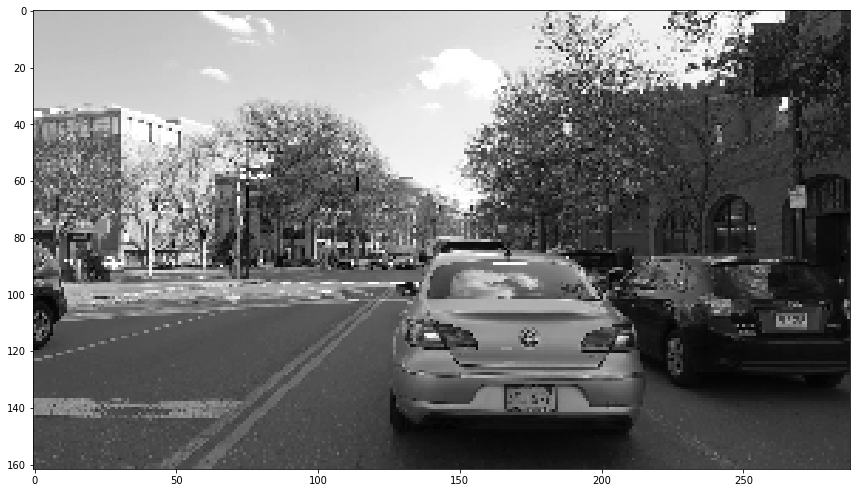

In [33]:
# Lets take a look at that same image after preprocessing
test_image = preprocess_image(df.X_path[0], target_shape=RESIZED_IMAGE_SHAPE)
imshow(test_image.reshape(RESIZED_IMAGE_SHAPE))

In [39]:
test_image.shape

(162, 288, 1)

In [40]:
test_image.dtype

dtype('float32')

In [41]:
# Lets take a look at the preprocess labels for the above image 
test_output = create_labels_array(df.label_path[0], target_shape=RESIZED_IMAGE_SHAPE)
test_output.shape

Processing file at: labels/000000_gt_id.png


(162, 288, 13)

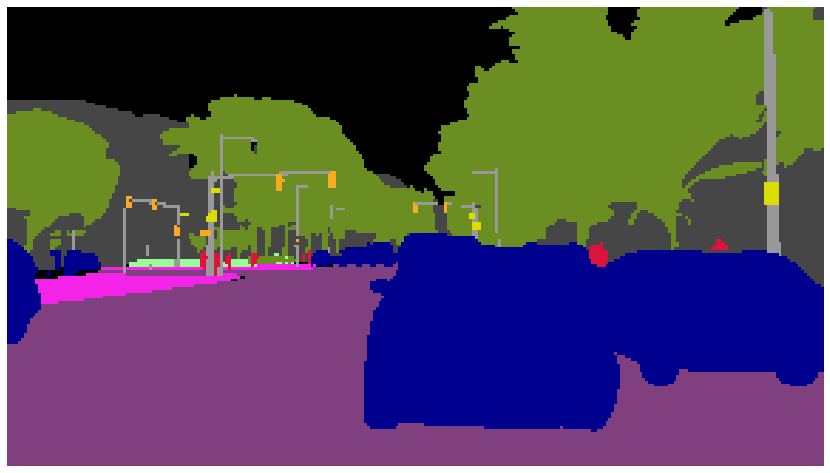

In [42]:
test_labels = test_output.argmax(axis=-1)
imshow(color_image_from_labels(test_labels, class_info_df))
plt.axis('off')
plt.show()

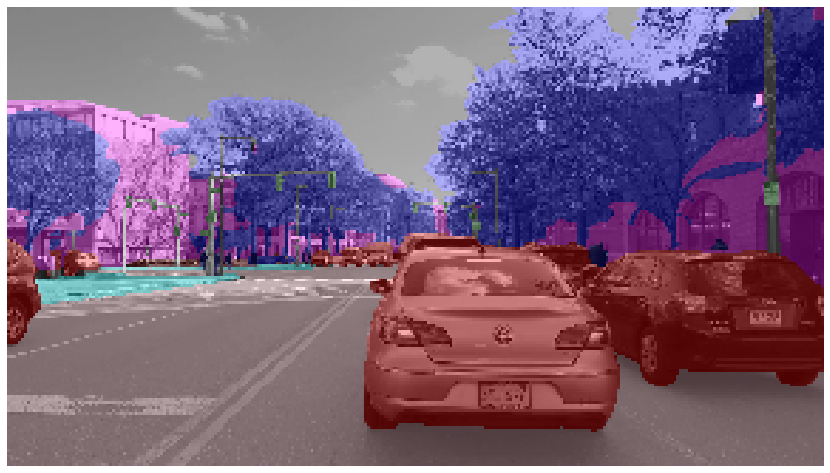

In [43]:
# and overlaying them as before
imshow(label2rgb(test_labels, test_image.reshape(RESIZED_IMAGE_SHAPE), colors=color_list, bg_label=0))
plt.axis('off')
plt.show()

In [44]:
# Lets do a test batch of preprocessing make sure you have the original data downloaded if you want to run this
data_subset = 100
X = np.empty((data_subset, ) + PREPROCESS_IMAGE_SHAPE, dtype='float32')
for i in range(data_subset):
    X[i] = preprocess_image(df.X_path[i], RESIZED_IMAGE_SHAPE)


y = np.empty((data_subset, ) + OUTPUT_SHAPE)

for i in range(data_subset):
    y[i] = create_labels_array(df.label_path[i], RESIZED_IMAGE_SHAPE)


Processing file at: labels/000099_gt_id.png


In [45]:
X.shape

(100, 162, 288, 1)

In [46]:
# We will save our preprocessed numpy arrays as compressed npz filles for use later
np.savez_compressed('test_preprocessed', x_gs_50=X, y_50=y)

In [47]:
loded_dataset = np.load('test_preprocessed.npz')

In [48]:
y_loded = loded_dataset['y_50']

In [49]:
y_loded.shape

(100, 162, 288, 13)

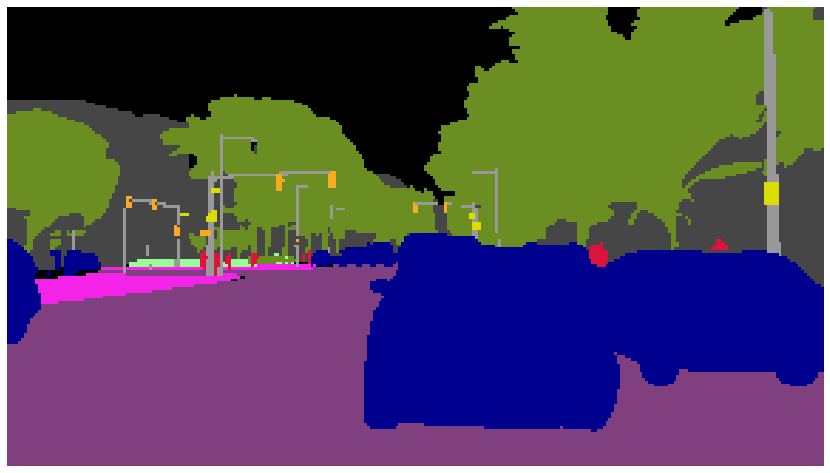

In [50]:
# We can see our data was saved and loaded successfully
imshow(color_image_from_labels(y_loded[0].argmax(-1), class_info_df))
plt.axis('off')
plt.show()

In [51]:
# Now we can process our dataset. I've commented this code out because it takes
# a while to run. If inclueded the npz file of the preprocessed data in the 
# project repo but if you want to download the original data you can test this

# data_subset = 5000
# X = np.empty((data_subset, ) + PREPROCESS_IMAGE_SHAPE, dtype='float32')
# for i in range(data_subset):
#     X[i] = preprocess_image(df.X_path[i], RESIZED_IMAGE_SHAPE)


# y = np.empty((data_subset, ) + OUTPUT_SHAPE, dtype='uint8')

# for i in range(data_subset):
#     y[i] = create_labels_array(df.label_path[i], RESIZED_IMAGE_SHAPE)



# np.savez_compressed('preprocessed_15_pct', X_saved=X, y_saved=y)


In [34]:
# Now we can load our preprocessed data
with np.load('preprocessed_15_pct.npz') as loded:
  X = loded['X_saved']
  y = loded['y_saved']

In [35]:
X[0].shape

(162, 288, 1)

In [36]:
y[0].shape

(162, 288, 13)

In [37]:
# This function creates a comparison of the true and predicted labels so we can 
# visually evaluate our models
def visualize_results(X_input, y_true, y_preds, index):
  labels_true = y_true[index].argmax(axis=-1)
  labels_image_true = color_image_from_labels(labels_true, class_info_df)

  labels_pred = y_preds[index].argmax(axis=-1)
  labels_image_pred = color_image_from_labels(labels_pred, class_info_df)

  image = X_input[index].reshape(RESIZED_IMAGE_SHAPE)

  
  fig, ax = plt.subplots(2,2)
  fig.figsize = [15, 15]
  ax[0, 0].imshow(labels_image_true)
  ax[0, 0].axis('off')
  ax[0, 0].set_title('True')
  ax[0, 1].imshow(labels_image_pred)
  ax[0, 1].axis('off')
  ax[0, 1].set_title('Predicted')
  ax[1, 0].imshow(label2rgb(labels_true, image, colors=color_list, bg_label=0))
  ax[1, 0].axis('off')
  ax[1, 1].imshow(label2rgb(labels_pred, image, colors=color_list, bg_label=0))
  ax[1, 1].axis('off')
  plt.tight_layout()
  plt.show()

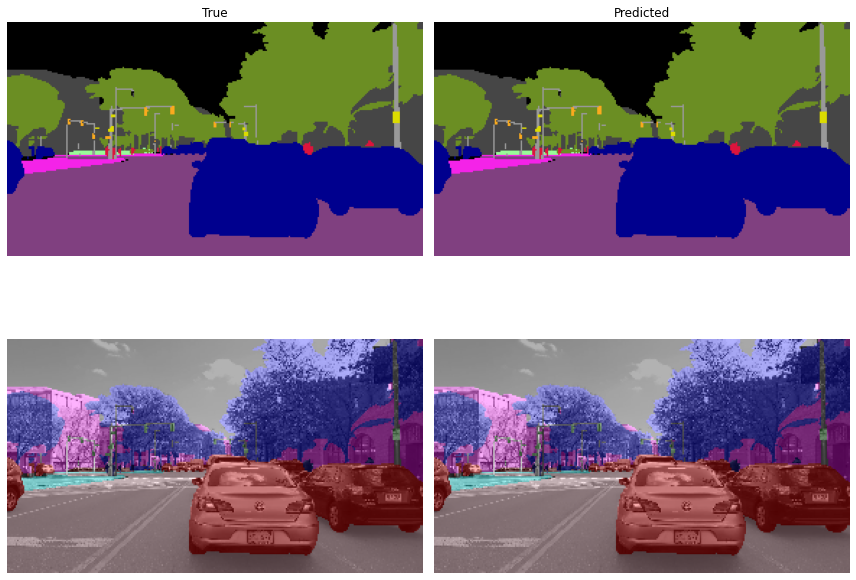

In [56]:
# We don't have any predictions yet so we will test it on the same true values
visualize_results(X, y, y, 0)

### Modeling

In [38]:
# To start our modeling we will split our data into training and test sets
# The images are part of a sequence so we will not shuffle our split
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, shuffle=False)

In [39]:
# the mean intersection over union metric included in keras is supposed to be usefull in this type of 
# segmentation problem be we need to modify it slighly to work with our data format
from tensorflow.keras.metrics import MeanIoU
from tensorflow import argmax

class MyMeanIOU(MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(argmax(y_true, axis=-1), argmax(y_pred, axis=-1), sample_weight)

In [59]:
# we will start with a model with 3 dense layers with ReLU activation 
# befor the softmax output layer
def build_model_dense(batch_size=50, epochs=20, dropout_rate=0.5):
  clear_session()
  input_images = Input(shape=PREPROCESS_IMAGE_SHAPE, name='Images input')
  flatten = Flatten()(input_images)
  dense1 = Dense(256, activation='relu')(flatten)
  dense2 = Dense(256, activation='relu')(dense1)
  dense3 = Dense(256, activation='relu')(dense2)
  dropout = Dropout(dropout_rate)(dense3)
  output = Dense(FLATTENED_IMAGE_SHAPE * NUM_CLASSES, activation='softmax')(dropout)
  reshape_output = Reshape(OUTPUT_SHAPE)(output)
  model = Model(inputs=input_images, outputs=reshape_output)
  
  print(model.summary())

  model.compile(optimizer='adam', loss='categorical_crossentropy', 
                metrics=[MyMeanIOU(num_classes=13),'accuracy'])

  history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), 
            epochs=epochs, batch_size=batch_size)
  return history, model

In [60]:
model_dense1_results = build_model_dense(dropout_rate=0.5)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images input (InputLayer)    [(None, 162, 288, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               11944192  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 606528)            155877

In [61]:
model_dense1_results[1]

32/32 [==============================] - 2s 45ms/step - loss: 1.4277 - my_mean_iou: 0.1626 - accuracy: 0.5356


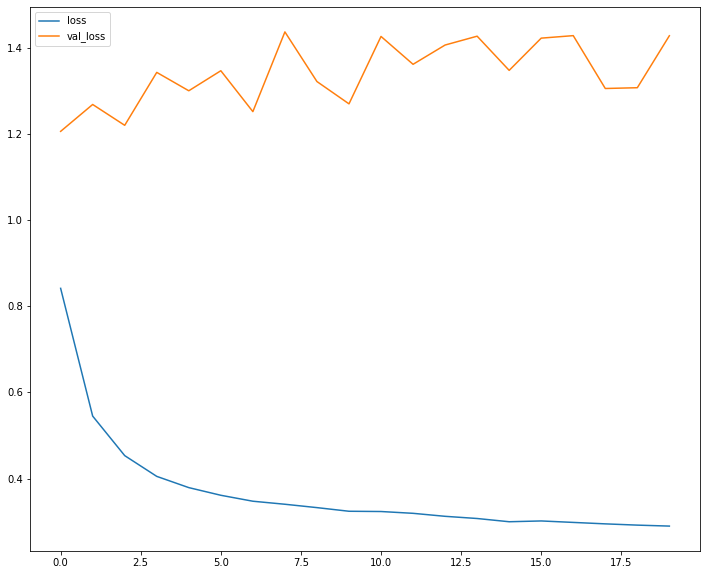

In [62]:
# Our first model dose not look like it's preforming very well, with only 53% accuracy on the test set
# Note the model accuracy can vary by + or - 5% if you rerun the training
model_dense1_results[1].evaluate(X_test, y_test)

dense1_results_df = pd.DataFrame(model_dense1_results[0].history)
dense1_results_df[['loss', 'val_loss']].plot()
plt.show()

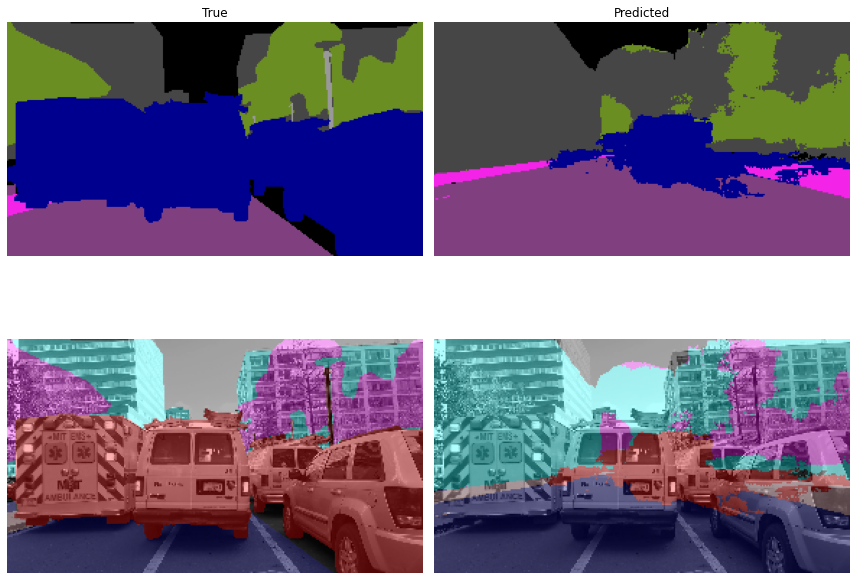

In [63]:
# Get a random image from the test set to visualize
random_test_image_index = np.random.randint(1, y_test.shape[0] -  1)
y_test_pred_dense1 = model_dense1_results[1].predict(X_test[random_test_image_index: random_test_image_index + 1])
visualize_results(X_test[random_test_image_index: random_test_image_index + 1], 
                  y_test[random_test_image_index: random_test_image_index + 1], y_test_pred_dense1, 0)

In [40]:
# Lets try adding some convolutional layters to our model
def build_model_conv(filters=32, batch_size=50, epochs=20, dropout_rate=0.5, strides=1, callbacks=None):
  clear_session()
  input_images = Input(shape=PREPROCESS_IMAGE_SHAPE, name='Images input')

  conv1 = Conv2D(filters, (3,3), strides=(strides, strides), padding='same', activation='relu')(input_images)
  max_pool1 = MaxPool2D(pool_size=(2,2))(conv1)

  conv2 = Conv2D(filters, (3,3), strides=(strides, strides), padding='same', activation='relu')(max_pool1)
  max_pool2 = MaxPool2D(pool_size=(2,2))(conv2)

  conv3 = Conv2D(filters, (3,3), strides=(strides, strides), padding='same', activation='relu')(max_pool2)
  max_pool3 = MaxPool2D(pool_size=(2,2))(conv3)

  flatten = Flatten()(max_pool3)

  dense1 = Dense(256, activation='relu')(flatten)
  dense2 = Dense(256, activation='relu')(dense1)
  dense3 = Dense(256, activation='relu')(dense2)

  dropout = Dropout(dropout_rate)(dense3)

  output = Dense(FLATTENED_IMAGE_SHAPE * NUM_CLASSES, activation='softmax')(dropout)
  reshape_output = Reshape(OUTPUT_SHAPE)(output)
  model = Model(inputs=input_images, outputs=reshape_output)
  
  print(model.summary())

  model.compile(optimizer='adam', loss='categorical_crossentropy', 
                metrics=[MyMeanIOU(num_classes=13),'accuracy'])

  history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), 
            epochs=epochs, batch_size=batch_size, callbacks=callbacks)
  return history, model

In [92]:
model_conv1_results = build_model_conv(dropout_rate=0.5, strides=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images input (InputLayer)    [(None, 162, 288, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 162, 288, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 81, 144, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 81, 144, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 36, 32)        0     

32/32 [==============================] - 2s 45ms/step - loss: 1.2033 - my_mean_iou: 0.1888 - accuracy: 0.5906


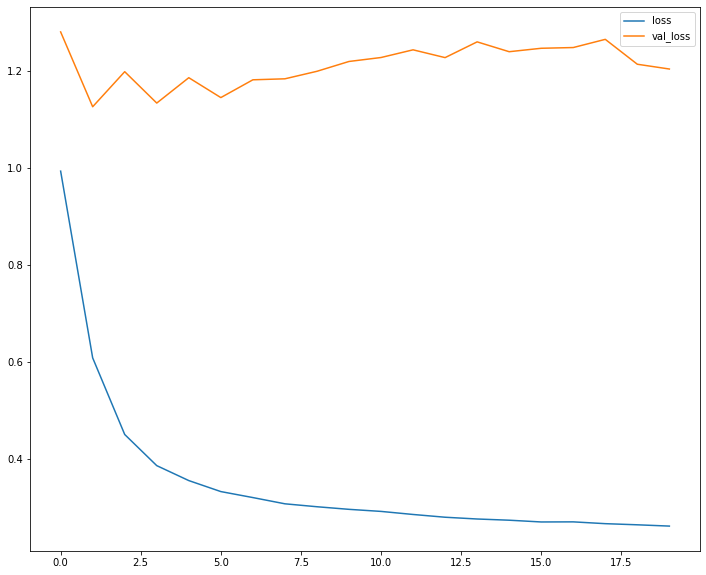

In [93]:
# 59% is better than our other models but not enough to be useful. Lets see if we can improve 
model_conv1_results[1].evaluate(X_test, y_test)

conv1_results_df = pd.DataFrame(model_conv1_results[0].history)
conv1_results_df[['loss', 'val_loss']].plot()
plt.show()

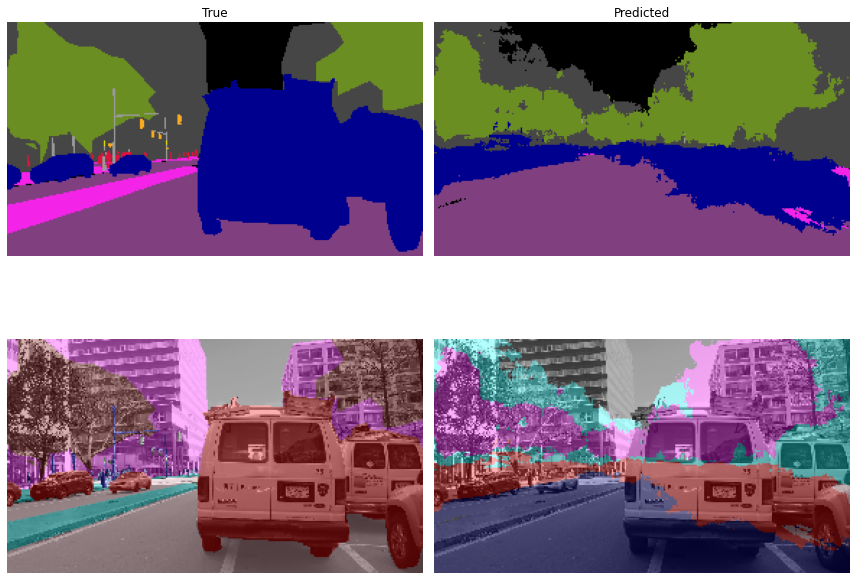

In [94]:
random_test_image_index = np.random.randint(1, y_test.shape[0] -  1)
y_test_pred_conv1 = model_conv1_results[1].predict(X_test[random_test_image_index: random_test_image_index + 1])
visualize_results(X_test[random_test_image_index: random_test_image_index + 1], 
                  y_test[random_test_image_index: random_test_image_index + 1], y_test_pred_conv1, 0)

In [68]:
# Let's try tuning our convolutional model with the keras tuner

!pip install -q -U keras-tuner
import kerastuner as kt

In [69]:
# define a new model builder function for the tuner
# Lets try adding some convolutional layters to our model
def build_model_conv_hp(hp):
  input_images = Input(shape=PREPROCESS_IMAGE_SHAPE, name='Images input')

  # Chose the number of filters for the conv layers
  hp_filters = hp.Int('filters', min_value = 8, max_value = 64, step = 8)

  conv1 = Conv2D(hp_filters, (3,3), padding='same', activation='relu')(input_images)
  max_pool1 = MaxPool2D(pool_size=(2,2))(conv1)

  conv2 = Conv2D(hp_filters, (3,3), padding='same', activation='relu')(max_pool1)
  max_pool2 = MaxPool2D(pool_size=(2,2))(conv2)

  conv3 = Conv2D(hp_filters, (3,3), padding='same', activation='relu')(max_pool2)
  max_pool3 = MaxPool2D(pool_size=(2,2))(conv3)

  flatten = Flatten()(max_pool3)

  # Chose the number of units for the dense layers
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 64)
  dense1 = Dense(hp_units, activation='relu')(flatten)
  dense2 = Dense(hp_units, activation='relu')(dense1)
  dense3 = Dense(hp_units, activation='relu')(dense2)

  # Chose the dropout rate
  hp_dropout_rate = hp.Choice('dropout_rate', values = [0.1, 0.25, 0.5, 0.75]) 
  dropout = Dropout(hp_dropout_rate)(dense3)

  output = Dense(FLATTENED_IMAGE_SHAPE * NUM_CLASSES, activation='softmax')(dropout)
  reshape_output = Reshape(OUTPUT_SHAPE)(output)
  model = Model(inputs=input_images, outputs=reshape_output)

  # Chose the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy',
                metrics=[MyMeanIOU(num_classes=13),'accuracy'])


  return model

In [70]:
tuner = kt.Hyperband(build_model_conv_hp, objective='val_accuracy', max_epochs=10, factor=3, directory='tuner_logs', project_name='drive_seg')

In [71]:
# Create a callback to clear the output after each training step
from tensorflow.keras.callbacks import Callback
class ClearTrainingOutput(Callback):
  def on_train_end(*args, **kwargs):
    clear_output(wait = True)

In [72]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[ClearTrainingOutput()])

Trial 30 Complete [00h 01m 56s]
val_accuracy: 0.08635078370571136

Best val_accuracy So Far: 0.6150070428848267
Total elapsed time: 00h 35m 39s
INFO:tensorflow:Oracle triggered exit


In [73]:
best_hps = tuner.get_best_hyperparameters()[0]

In [74]:
best_hps.get('filters')

64

In [75]:
best_hps.get('units')

288

In [76]:
best_hps.get('dropout_rate')

0.75

In [77]:
best_hps.get('learning_rate')

0.001

In [78]:
best_model = build_model_conv_hp(best_hps)

In [88]:

history_best = best_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), 
                          epochs=20, batch_size=50)

Epoch 1/20
80/80 [==============================] - 12s 146ms/step - loss: 0.3184 - my_mean_iou_1: 0.5535 - accuracy: 0.8795 - val_loss: 1.3283 - val_my_mean_iou_1: 0.1621 - val_accuracy: 0.5422
Epoch 2/20
80/80 [==============================] - 12s 146ms/step - loss: 0.3157 - my_mean_iou_1: 0.5569 - accuracy: 0.8810 - val_loss: 1.3020 - val_my_mean_iou_1: 0.1665 - val_accuracy: 0.5519
Epoch 3/20
80/80 [==============================] - 12s 146ms/step - loss: 0.3172 - my_mean_iou_1: 0.5547 - accuracy: 0.8799 - val_loss: 1.3036 - val_my_mean_iou_1: 0.1668 - val_accuracy: 0.5497
Epoch 4/20
80/80 [==============================] - 12s 147ms/step - loss: 0.3115 - my_mean_iou_1: 0.5589 - accuracy: 0.8816 - val_loss: 1.3442 - val_my_mean_iou_1: 0.1611 - val_accuracy: 0.5394
Epoch 5/20
80/80 [==============================] - 12s 147ms/step - loss: 0.3137 - my_mean_iou_1: 0.5581 - accuracy: 0.8809 - val_loss: 1.3849 - val_my_mean_iou_1: 0.1593 - val_accuracy: 0.5369
Epoch 6/20
80/80 [=======

32/32 [==============================] - 1s 46ms/step - loss: 1.4080 - my_mean_iou_1: 0.1564 - accuracy: 0.5295


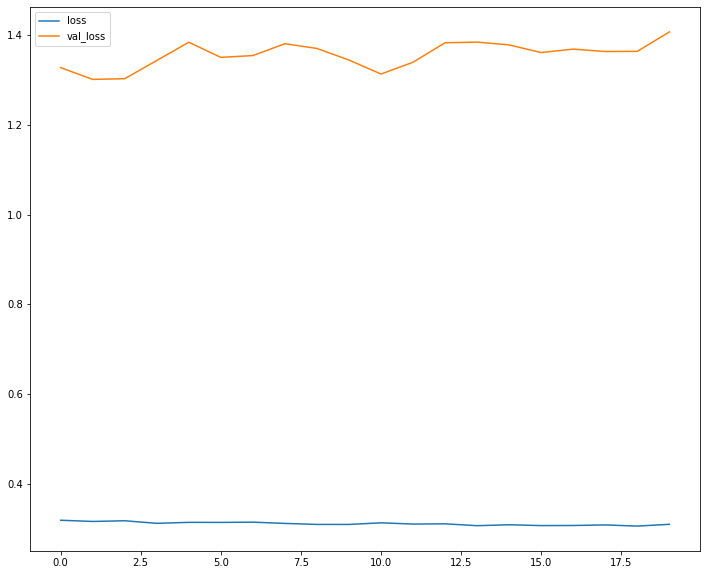

In [89]:
# The best model from our grid search is not preforming as well on the full dataset
best_model.evaluate(X_test, y_test)

conv1_results_df = pd.DataFrame(history_best.history)
conv1_results_df[['loss', 'val_loss']].plot()
plt.show()

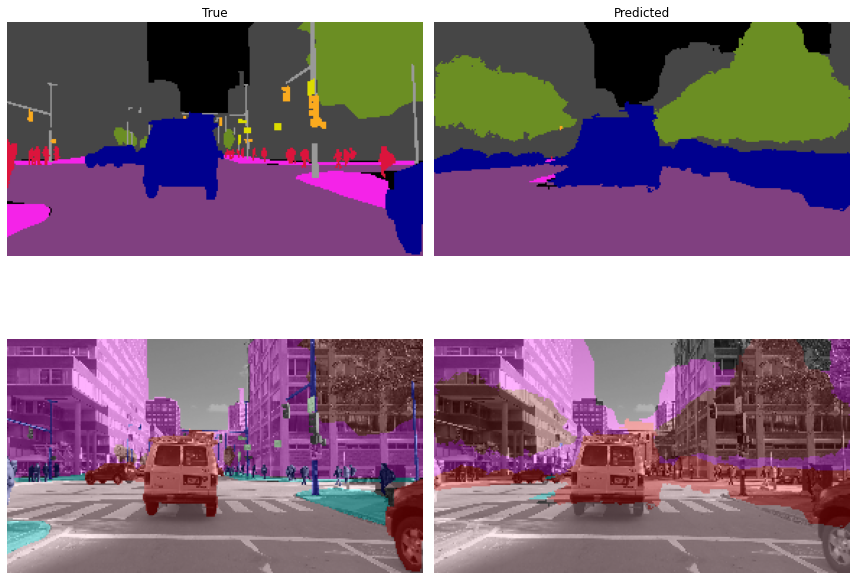

In [90]:
random_test_image_index = np.random.randint(1, y_test.shape[0] -  1)
y_test_pred_best = best_model.predict(X_test[random_test_image_index: random_test_image_index + 1])
visualize_results(X_test[random_test_image_index: random_test_image_index + 1], 
                  y_test[random_test_image_index: random_test_image_index + 1], y_test_pred_best, 0)

In [41]:
# Lets see if we can improve our original convolutional model by implementing early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop_callback = EarlyStopping(monitor='val_accuracy', patience=2)

In [42]:
model_conv_results_es = build_model_conv(dropout_rate=0.5, strides=1, callbacks=[early_stop_callback])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images input (InputLayer)    [(None, 162, 288, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 162, 288, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 81, 144, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 81, 144, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 36, 32)        0     

32/32 [==============================] - 2s 46ms/step - loss: 1.2350 - my_mean_iou: 0.1893 - accuracy: 0.5909


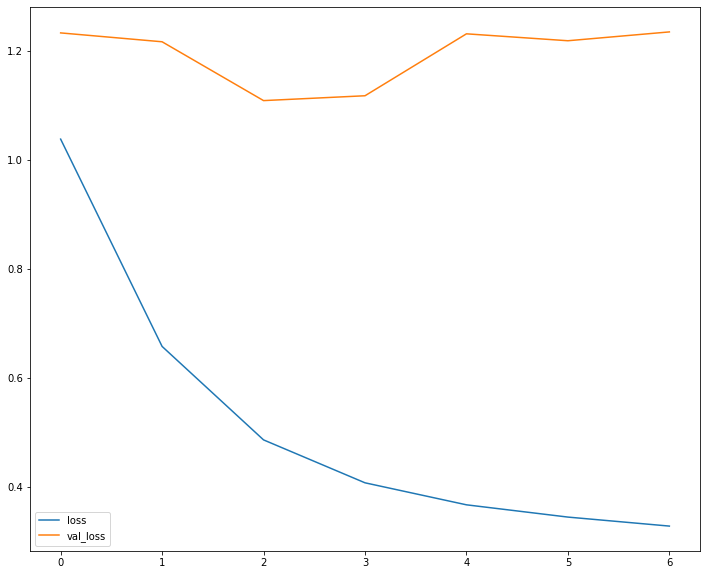

In [43]:
# It looks like we get approximatly the same validation accuracy by stopping after 7 epochs 
model_conv_results_es[1].evaluate(X_test, y_test)

conv_results_es_df = pd.DataFrame(model_conv_results_es[0].history)
conv_results_es_df[['loss', 'val_loss']].plot()
plt.show()

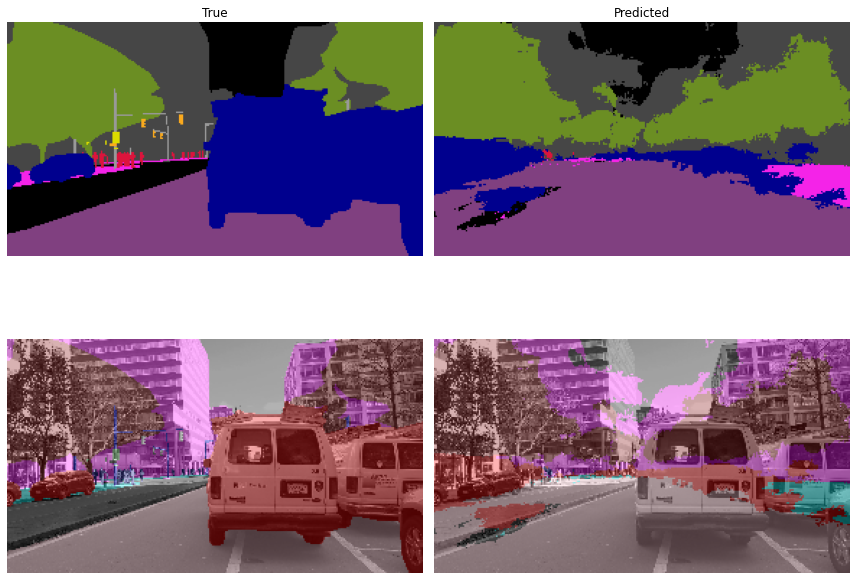

In [68]:
random_test_image_index = np.random.randint(1, y_test.shape[0] -  1)
y_test_pred_conv_es = model_conv_results_es[1].predict(X_test[random_test_image_index: random_test_image_index + 1])
visualize_results(X_test[random_test_image_index: random_test_image_index + 1], 
                  y_test[random_test_image_index: random_test_image_index + 1], y_test_pred_conv_es, 0)

In [47]:
# Lets take a look at some more mtrics of our last model
from tensorflow.math import confusion_matrix

In [69]:
y_test_true = y_test.argmax(axis=-1).reshape(-1)
y_test_true

array([7, 7, 7, ..., 3, 3, 3])

In [70]:
y_test_pred = model_conv_results_es[1].predict(X_test).argmax(axis=-1).reshape(-1)
y_test_pred

array([7, 7, 7, ..., 3, 3, 3])

In [71]:
cm_array = confusion_matrix(y_test_true, y_test_pred, NUM_CLASSES).numpy()
cm_array

array([[2078273,  204310,     492,  428607,   19386,     213,       0,
         776395,    1799,  505735,   13464,     108,       0],
       [ 103374, 6377652,    9188, 2036625,  501136,    1536,       0,
        1462282,   11240, 1379860,    5426,      22,      74],
       [   2948,  148630,    5217,   25869,   17767,    1018,       0,
          93143,    7551,   16955,     223,       0,       0],
       [  45679,  661039,    3335, 9059794,  553261,     814,       0,
           4689,    3936,     317,     182,       0,       0],
       [  20045,  267865,    1772,  316493,  175453,    1325,       0,
          36347,    7401,    6101,      65,       0,       0],
       [    637,   15315,    2489,    7860,    5570,     266,       0,
           3610,    3841,     628,       2,       0,       0],
       [      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0],
       [1799433,  817751,    6249,   23766,   14661,    2491, 

In [54]:
import seaborn as sns

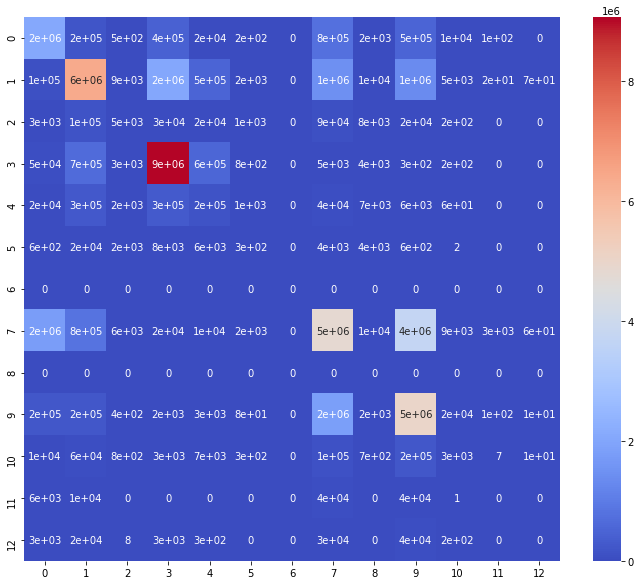

In [80]:
sns.heatmap(cm_array, annot=True,fmt='.1g', cmap='coolwarm')

In [87]:
test_results_df = class_info_df.copy()
test_results_df.drop('color', axis=1, inplace=True)
test_results_df

,label,id
0,unknown,0
1,vehicle,1
2,pedestrian,2
3,road,3
4,sidewalk,4
5,bicycle,5
6,motorcycle,6
7,building,7
8,terrain,8
9,vegetation,9


In [91]:
test_results_df['true_count'] = pd.Series(y_test_true).value_counts()
test_results_df['pred_counts'] = pd.Series(y_test_pred).value_counts()

In [92]:
test_results_df

,label,id,true_count,pred_counts
0,unknown,0,4028782.0,4289893.0
1,vehicle,1,11888415.0,8815236.0
2,pedestrian,2,319321.0,29957.0
3,road,3,10333046.0,11906723.0
4,sidewalk,4,832867.0,1297166.0
5,bicycle,5,40218.0,7990.0
6,motorcycle,6,NaN,NaN
7,building,7,11269275.0,9240246.0
8,terrain,8,NaN,51220.0
9,vegetation,9,7326758.0,10965198.0


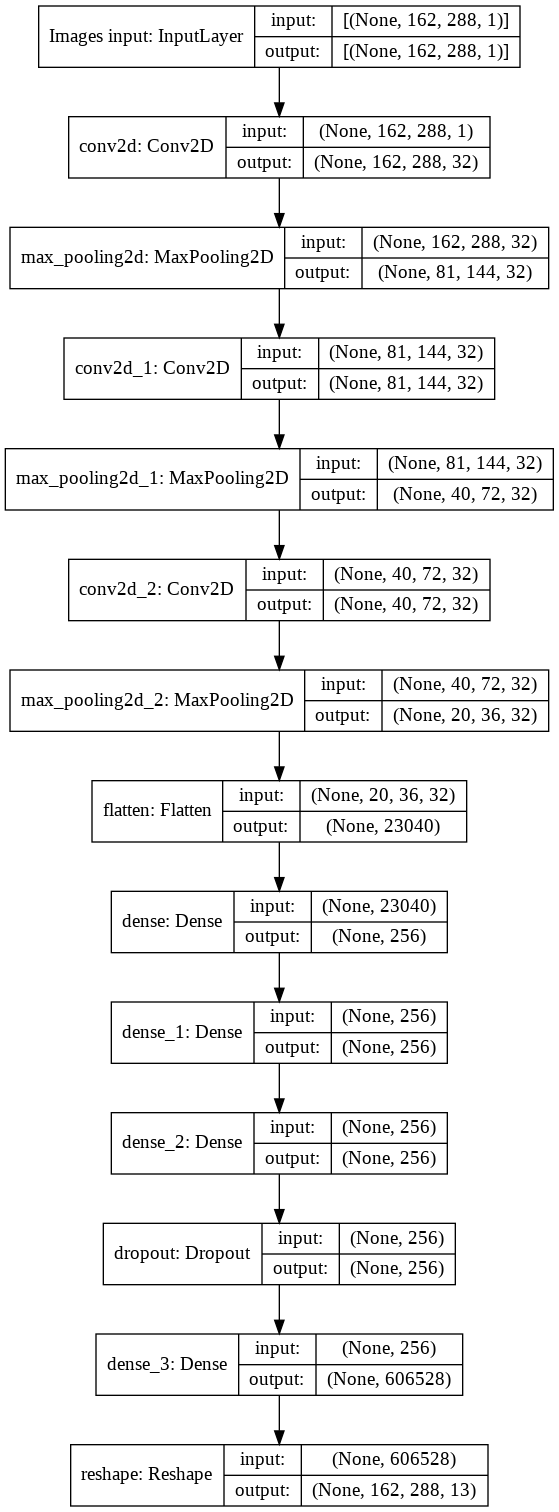

In [81]:
plot_model(model_conv_results_es[1], show_shapes=True)

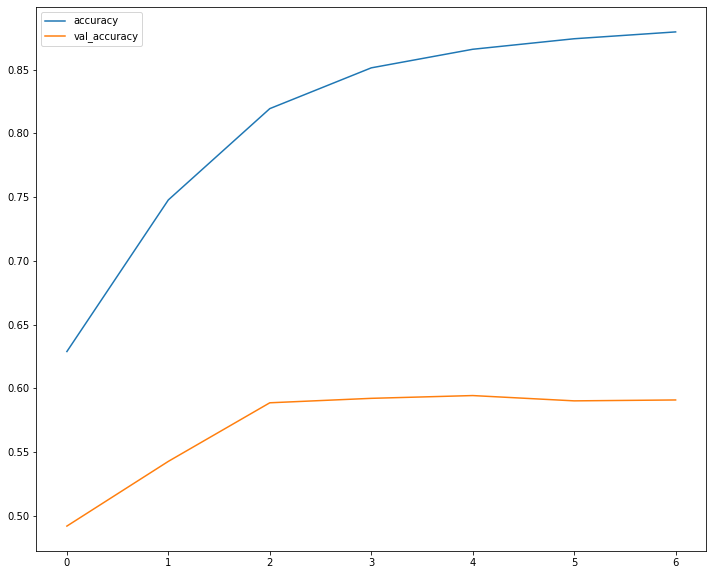

In [77]:
conv_results_es_df[['accuracy', 'val_accuracy']].plot()
plt.show()

### Results and next steps
In this project I developed a methodology for building and models for semantic image segmentation. While I was not able to produce a satisactory model for use in a production image labeling system in the time I had, there are many areas to epxplore that could produce better results. Some examples incluede:
- Appling additional preprocessing filters to the input images
- Improve nural network architecture 
- Explre transfer learning
- Improve performance using spark or other big data tools 

Future project goal once performance is improved:
- Build a model that can use full resolution color images
- Build a web interface that takes uploded images and feeds them into the model to prodce labeled datasets 
